In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm
from matplotlib.pyplot import cm

import argparse

import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils

import geopandas

from numba import jit
import numpy as npF
from numba import guvectorize, float64, int64, void

import scipy.signal as signal


In [11]:
import sparse

In [47]:
CGP_df = pd.read_csv('mod_coal_inputs/BC_limited_country_SEA_GAINS_Springer.csv')

CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})
CGP_df['unique_ID'] =  pd.factorize(CGP_df['UNIT'])[0] + 1

In [34]:

################## Parse arguments and set constants ##############


years = 50
coal_year_range = np.arange(0, 45)[::5]
percent = np.arange(0,101)[::5]

weighted_co2 = True

country_emit = 'INDONESIA'

## Add time dimension
length_simulation = years*365
time_array = np.arange(0, length_simulation)

## Days per season
season_days = {'DJF': 90, 'MAM':92, 'JJA':92, 'SON':91}


## import the china global powerplant database
### Gallagher, Kevin P. (2021), “China’s Global Energy Finance,” Global Development Policy Center, Boston University.
### Gallagher, Kevin P., Li, Zhongshu, Chen, Xu, Ma, Xinyue (2019), “China’s Global Power Database,” Global Development Policy Center, Boston University.

CGP_df = pd.read_csv('mod_coal_inputs/BC_limited_country_SEA_GAINS_Springer.csv')

CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})
CGP_df['unique_ID'] =  pd.factorize(CGP_df['UNIT'])[0] + 1
## reduce to one country for emissions
min_year = CGP_df['Year_of_Commission'].min()
CGP_df = CGP_df.loc[CGP_df['COUNTRY'] == country_emit]

print('Emis data prepped and loaded')


######## Country mask and dataframe ######

country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
country_df = geopandas.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
countries = ['China','Australia', 'India','Myanmar', 'Cambodia', 'Laos','Philippines','Nepal','Bangladesh','Thailand','Bhutan','Brunei','Singapore', 'Papua New Guinea', 'Solomon Islands', 'East Timor', 'Taiwan']
country_df = country_df.rename(columns = {'SOVEREIGNT':'country'})

ds_area = xr.open_dataset('/net/fs11/d0/emfreese/GCrundirs/IRF_runs/stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4', engine = 'netcdf4')
utils.fix_area_ij_latlon(ds_area);


######## Set health data #########

RR = 1.02 #global mean
del_x = 10 #ug/m3
beta = np.log(RR)/del_x


#2019 mortalities to match 2019 population data from the GBD 
I_val = {}
I_val['China'] = 10462043.68
I_val['Indonesia'] = 35874.09
I_val['Malaysia'] = 169483.46
I_val['Vietnam'] = 606145.89
I_val['Australia'] = 169053.20
I_val['Cambodia'] = 96284.85
I_val['Myanmar'] = 368031.84
I_val['Laos'] = 35874.09
I_val['Philippines'] = 557809.29
I_val['Nepal'] = 170032.44
I_val['Bangladesh'] = 740684.73
I_val['Thailand'] = 486556.52
I_val['Bhutan'] = 3713.40

I_val_df = pd.DataFrame(I_val.values(), index = I_val.keys()).rename(columns = {0:'Ival'}) 
I_val_df.index.rename('country', inplace = True)
pop_df = country_df.loc[country_df['country'].isin(countries)].loc[country_df['POP_YEAR'] == 2019][['country','POP_EST']].set_index('country').groupby('country').max() #select 2019 population data
I0_pop_df = pd.merge(pop_df, I_val_df, left_index=True, right_index=True) #combine Initial mortality and total population by country
I0_pop_df['I_obs'] = I0_pop_df['Ival']/I0_pop_df['POP_EST'] #calculate initial mortality rate, I_obs

regrid_area_ds = xr.open_dataset('Outputs/regridded_population_data.nc')


    


Emis data prepped and loaded


In [35]:
###### testing

In [75]:
def individual_plant_shutdown(years_running, df, time_array, typical_shutdown_years, unique_id):
    ''' Shutdown a unit early. The df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day
        year_early is the number of years the plant runs
        min_comission_yr is the earliest year a plant was built and is where our timeline starts
        time_array is the length of time for our simulation
        shutdown_years is the typical lifetime of a coal plant'''
    shutdown_days = typical_shutdown_years*365
    E = np.zeros(len(time_array))
    new_CGP = df.loc[df['unique_ID'] == unique_id]
    yr_offset = (new_CGP['Year_of_Commission'].iloc[0] - min_year)
    test_array = np.where((time_array <= (yr_offset + years_running)*365) & (time_array >= yr_offset * 365), True, False)
    E += test_array* new_CGP['BC_(g/day)'].sum()
    return(E)


In [76]:
CGP_df.loc[CGP_df['unique_ID'] == 10]['Year_of_Commission'].iloc[0]

2009.0

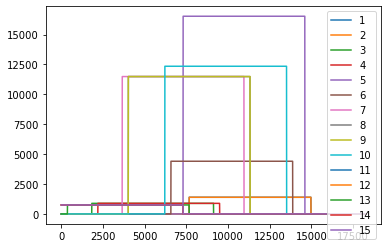

In [77]:
for idx in CGP_df['unique_ID'].values[:15]:
    plt.plot(individual_plant_shutdown(20, CGP_df, time_array, 40, idx), label = idx)
    plt.legend()

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display

from scipy import signal


# In[2]:



import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})



In [2]:

# # Options

# In[3]:


r = ['all_countries']
month = 'Jan' #options are Jan, Apr, Jul, Oct
time = '20160'
length_simulation = 60 #days
diagnostic = 'SpeciesConc'


# ## Import data

dict_conc = {}
dict_emis = {}

#15x step for GF
dict_conc['all_countries_step'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_2x/all_countries/Jan/mod_output/GEOSChem.{diagnostic}.{time}*', combine = 'by_coords')
#pulse run
dict_conc['all_countries_pulse'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_2x_pulse/all_countries/Jan/mod_output/GEOSChem.{diagnostic}.{time}*', combine = 'by_coords')
#1.5e-10 addition run
dict_conc['all_countries_add'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/all_countries_add/Jan/mod_output/GEOSChem.{diagnostic}.{time}*', combine = 'by_coords')
#complex test run
dict_conc['all_countries_cos'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/all_countries_cos/Jan/mod_output/GEOSChem.{diagnostic}.{time}*', combine = 'by_coords')

#15x step for GF
dict_emis['all_countries_step'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_2x/all_countries/Jan/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')
#pulse run
dict_emis['all_countries_pulse'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_2x_pulse/all_countries/Jan/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')
#1.5e-10 addition run
dict_emis['all_countries_add'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/all_countries_add/Jan/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')
#complex test run
dict_emis['all_countries_cos'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/all_countries_cos/Jan/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')

#base run
dict_conc['base'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan/mod_output/GEOSChem.{diagnostic}.{time}*', combine = 'by_coords', engine = 'netcdf4')
dict_emis['base'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords', engine = 'netcdf4')


#combine data
ds_conc = xr.concat([dict_conc[r] for r in dict_conc.keys()], pd.Index([r for r in dict_conc.keys()], name='run'))
ds_emis = xr.concat([dict_emis[r] for r in dict_emis.keys()], pd.Index([r for r in dict_emis.keys()], name='run'))

#modify data
ds_conc['time'] = ds_conc['time'].astype('datetime64')
utils.switch_conc_time(ds_conc)
#change the time to be delta time
#ds_conc['time'] = ds_conc['time']-ds_conc['time'][0]
#fix the area
ds_conc = utils.fix_area_ij_latlon(ds_conc)
#sum all BC conc
ds_conc['BC_total'] = ds_conc['SpeciesConc_BCPI'] + ds_conc['SpeciesConc_BCPO']
ds_emis = utils.fix_area_ij_latlon(ds_emis)
ds_emis = ds_emis.isel(lev = -1) #select surface since we only have surface emissions
utils.combine_BC(ds_emis)


### Add height to data
height_ds = utils.height_ds
ds_conc = xr.merge([ds_conc, height_ds], join = 'inner')


### convert to correct units
def ppb_to_ug(ds, species_to_convert, mw_species_list, P, T):
    '''Convert species to ug/m3 from ppb'''
    R = 8.314 #J/K/mol
    mol_per_m3= (P / (T * R)) #Pa/K/(J/K/mol) = mol/m3
    
    for spec in species_to_convert:
        attrs = ds[spec].attrs
        ds[spec] = ds[spec]*mw_species_list[spec]*mol_per_m3*1e-3 #ppb*g/mol*mol/m3*ug/ng
        ds[spec].attrs['units'] = 'μg m-3'

mw_BC = {'BC_total':12.011}



In [9]:
T_p_ds = xr.open_mfdataset('/net/geoschem/data/gcgrid/data/ExtData/GEOS_0.5x0.625/MERRA2/2016/*/MERRA2.2016*.I3.05x0625.nc4')
T_p_ds = T_p_ds.groupby('time.date').mean(dim = 'time').rename({'date':'time'})



In [ ]:
#create regridder (reusing weights)
regridder = xe.Regridder(T_p_ds, dict_conc[list(dict_conc.keys())[0]], 'bilinear', reuse_weights = True, weights = 'tp_bilinear_weights.nc')
regridder  # print basic regridder information.

#regrid according to our ds_out grid
T_p_ds = regridder(T_p_ds)
T_p_ds = T_p_ds.isel(time = slice(0, len(ds_conc['time'])))
T_p_ds['time'] = ds_conc['time']

pressure_ds = utils.pressure_ds


ds_conc['BC_total'] = ds_conc['BC_total']*1e9 #convert mol/mol to ppb
ppb_to_ug(ds_conc, ['BC_total'], mw_BC, pressure_ds, T_p_ds['T'])


In [ ]:
T_p_ds['time']  = T_p_ds['time'] - T_p_ds['time'][0]
